In [2]:
import os
import sys
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from scipy import stats
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'
import matplotlib.dates as mdates

def get_hstr(path):
    hstr = pd.read_csv(path)
    hstr['datetime'] = pd.to_datetime(hstr['CLCT_UNIX_TM'], unit='s', utc=True)
    hstr['datetime'] = hstr['datetime'].dt.tz_convert('Asia/Seoul').dt.strftime('%Y-%m-%d %H:%M:%S')
    hstr['datetime'] = hstr['datetime'].astype('datetime64[ns]')
    hstr.columns = ['현장교차로ID', '수집유닉스시각', '수집일시', '제어구분코드', '제어상태코드', '주기시간', '옵셋시간',
        'A링1현시시간', 'A링2현시시간', 'A링3현시시간', 'A링4현시시간', 'A링5현시시간', 'A링6현시시간',
        'A링7현시시간', 'A링8현시시간', 'B링1현시시간', 'B링2현시시간', 'B링3현시시간', 'B링4현시시간',
        'B링5현시시간', 'B링6현시시간', 'B링7현시시간', 'B링8현시시간', 'A링1현시보행시간',
        'A링2현시보행시간', 'A링3현시보행시간', 'A링4현시보행시간', 'A링5현시보행시간', 'A링6현시보행시간',
        'A링7현시보행시간', 'A링8현시보행시간', 'B링1현시보행시간', 'B링2현시보행시간', 'B링3현시보행시간',
        'B링4현시보행시간', 'B링5현시보행시간', 'B링6현시보행시간', 'B링7현시보행시간', 'B링8현시보행시간',
        '수집날짜시각']
    cols = list(hstr.columns).copy()
    cols.remove('수집날짜시각')
    cols.insert(1, '수집날짜시각')
    hstr = hstr[cols]
    return hstr

inter_nos = list(range(5031, 5048))

In [3]:
# 성남시 신호이력 데이터
s_tod_his = pd.read_csv('seongnam/S_TOD_HIS_1702597659892.csv')

# 인천시 신호이력 데이터
'''SELECT * FROM soitdspotintsoperhstr WHERE SPOT_INTS_ID BETWEEN 5031 AND 5047'''
csv_files = [f for f in os.listdir('incheon') if f.endswith('.csv')]

dfs = []
for file in csv_files:
    df_name = file.replace('.csv', '')
    print(df_name)
    globals()[df_name] = get_hstr(f'incheon/{file}')
    dfs.append(globals()[df_name])
    print(sorted([dt for dt in globals()[df_name]['수집날짜시각'] if dt.hour != 23])[0])
    print(sorted([dt for dt in globals()[df_name]['수집날짜시각'] if dt.hour != 23])[-1])
hstr = pd.concat(dfs).drop_duplicates().sort_values(by='수집날짜시각').reset_index(drop=True)
hstr = hstr[['현장교차로ID', '수집날짜시각', '주기시간', '옵셋시간',
             'A링1현시시간', 'A링2현시시간', 'A링3현시시간', 'A링4현시시간', 'A링5현시시간', 'A링6현시시간',
             'B링1현시시간', 'B링2현시시간', 'B링3현시시간', 'B링4현시시간', 'B링5현시시간', 'B링6현시시간']]
hstr = hstr[hstr.수집날짜시각.dt.day >= 12]
print(len(hstr))
print(sorted([dt for dt in hstr['수집날짜시각'] if dt.hour != 23])[0])
print(sorted([dt for dt in hstr['수집날짜시각'] if dt.hour != 23])[-1])

soitdspotintsoperhstr_202312110921
2023-12-10 09:00:00
2023-12-11 09:21:31
soitdspotintsoperhstr_202312120814
2023-12-11 09:00:57
2023-12-12 08:14:02
soitdspotintsoperhstr_202312131102
2023-12-12 09:00:58
2023-12-13 11:02:54
soitdspotintsoperhstr_202312141254
2023-12-13 09:00:58
2023-12-14 12:53:54
soitdspotintsoperhstr_202312150926
2023-12-14 09:00:58
2023-12-15 09:26:01
soitdspotintsoperhstr_202312151700
2023-12-15 09:00:58
2023-12-15 16:59:54
32466
2023-12-12 00:00:09
2023-12-15 16:59:54


In [4]:
infos = {}
# 신호이력
infos['hstr'] = {inter_no:hstr_temp for (inter_no, hstr_temp) in hstr.groupby('현장교차로ID')}
# 현시 개수
infos['number_of_phases'] = {}
for inter_no in inter_nos:
    a_ring_columns = [col for col in infos['hstr'][inter_no].columns if 'A링' in col]
    b_ring_columns = [col for col in infos['hstr'][inter_no].columns if 'B링' in col]
    max_a_ring = max([int(col[2]) for col in a_ring_columns if infos['hstr'][inter_no][col].any() != 0])
    max_b_ring = max([int(col[2]) for col in b_ring_columns if infos['hstr'][inter_no][col].any() != 0])
    if max_a_ring == max_b_ring:
        infos['number_of_phases'][inter_no] = max_a_ring
    else:
        raise "A링, B링 현시번호 최댓값이 서로 다름"
# 현시시간 목록
infos['durations'] = {inter_no:np.unique(infos['hstr'][inter_no].iloc[:,4:].values.flatten()) for inter_no in inter_nos}

In [5]:
# TOD 계획 데이터
todplans = pd.read_csv("soitdtodplan_202312181440.csv")
todplans.columns = ["현장교차로ID", "시각계획번호", "시각운영번호", "수집유닉스시각", "수집일시", "시작시", "시작분", "현시운영번호", "현시운영계획번호"]
todplans = todplans[(todplans['수집일시'] == 20231212) & (todplans['시각계획번호'] == 1) & (todplans['시작시']!=0)]

# 전이시각, ID
infos['transition_times'] = {inter_no:todplans[todplans.현장교차로ID == inter_no][['시작시', '시작분']] for inter_no in inter_nos}
infos['ID'] = {inter_no:todplans[todplans.현장교차로ID == inter_no].현시운영계획번호.unique() for inter_no in inter_nos}

# 시간계획 데이터
timeplans = pd.read_csv("soitdtimeplan_202312180943.csv")
timeplans.columns = ["현장교차로ID", "시간계획번호", "현시운영번호", "현시운영계획번호", "수집유닉스시각", "수집일시", "주기시간", "옵셋시간",
                     "A링1현시시간", "A링2현시시간", "A링3현시시간", "A링4현시시간", "A링5현시시간", "A링6현시시간", "A링7현시시간", "A링8현시시간",
                     "B링1현시시간", "B링2현시시간", "B링3현시시간", "B링4현시시간", "B링5현시시간", "B링6현시시간", "B링7현시시간", "B링8현시시간"]
timeplans = timeplans[(timeplans.시간계획번호 == 1)]
timeplan_list = []
for inter_no in inter_nos:
    timeplan_list.append(timeplans[(timeplans.현장교차로ID==inter_no) & (timeplans.현시운영계획번호.isin(infos['ID'][inter_no]))])
timeplans = pd.concat(timeplan_list)

# 이상치로 판단하지 않는 현시시간 / 이상치로 판단하는 현시시간
infos['accepted_durations'] = {}
infos['unaccepted_durations'] = {}

# 현시시간 빈도, 옵셋
infos['unique_durations'] = {}
infos['duration_frequencies'] = {}
infos['offsets'] = {}
infos['cycles'] = {}

for inter_no in inter_nos:
    phase_times = np.unique(timeplans[timeplans.현장교차로ID == inter_no].iloc[:, 8:].values.flatten())
    accepted_phase_times = np.unique(np.concatenate([phase_times - 1, phase_times, phase_times + 1]))
    infos['accepted_durations'][inter_no] = accepted_phase_times
    unaccepted_phase_times = sorted(set(infos['durations'][inter_no]) - set(accepted_phase_times))
    infos['unaccepted_durations'][inter_no] = unaccepted_phase_times

    unique_durations, frequencies = np.unique(infos['hstr'][inter_no].iloc[:,4:].values, return_counts=True)
    sorted_indices = np.argsort(frequencies)[::-1]
    infos['unique_durations'][inter_no] = unique_durations[sorted_indices]
    infos['duration_frequencies'][inter_no] = frequencies[sorted_indices]

    infos['offsets'][inter_no] = {}
    infos['cycles'][inter_no] = {}
    for _, row in infos['transition_times'][inter_no].iterrows():
        hour = row.시작시
        minute = row.시작분
        ID = todplans[(todplans.현장교차로ID==inter_no) & (todplans.시작시==hour) & (todplans.시작분==minute)].iloc[0].현시운영계획번호
        offset = timeplans[(timeplans.현장교차로ID==inter_no)&(timeplans.현시운영계획번호==ID)].iloc[0].옵셋시간
        cycle = timeplans[(timeplans.현장교차로ID==inter_no)&(timeplans.현시운영계획번호==ID)].iloc[0].주기시간
        infos['offsets'][inter_no][(hour, minute)] = offset
        infos['cycles'][inter_no][(hour, minute)] = cycle


In [6]:
print(infos['unique_durations'][5031])
print(infos['duration_frequencies'][5031])

[ 35  27   0  20  25  49  16  37  29  33  65  31  34  58  19  28  17  44
  18  51  30  43  40  39  50  32  66  36  48  26  56  21  54  38  22  52
  41  46  42  70  72  76  59  80  67  23 126 156  90  45  69  78  71  47
 161 179]
[4186 3992 3948 1586 1392 1384 1306 1306 1170  404  394  350  322  280
  276  162  142  140  130  120   98   94   92   82   50   44   20   20
   18   16   16   16   14   14   14   10   10    8    8    8    6    4
    4    4    4    4    2    2    2    2    2    2    2    2    2    2]


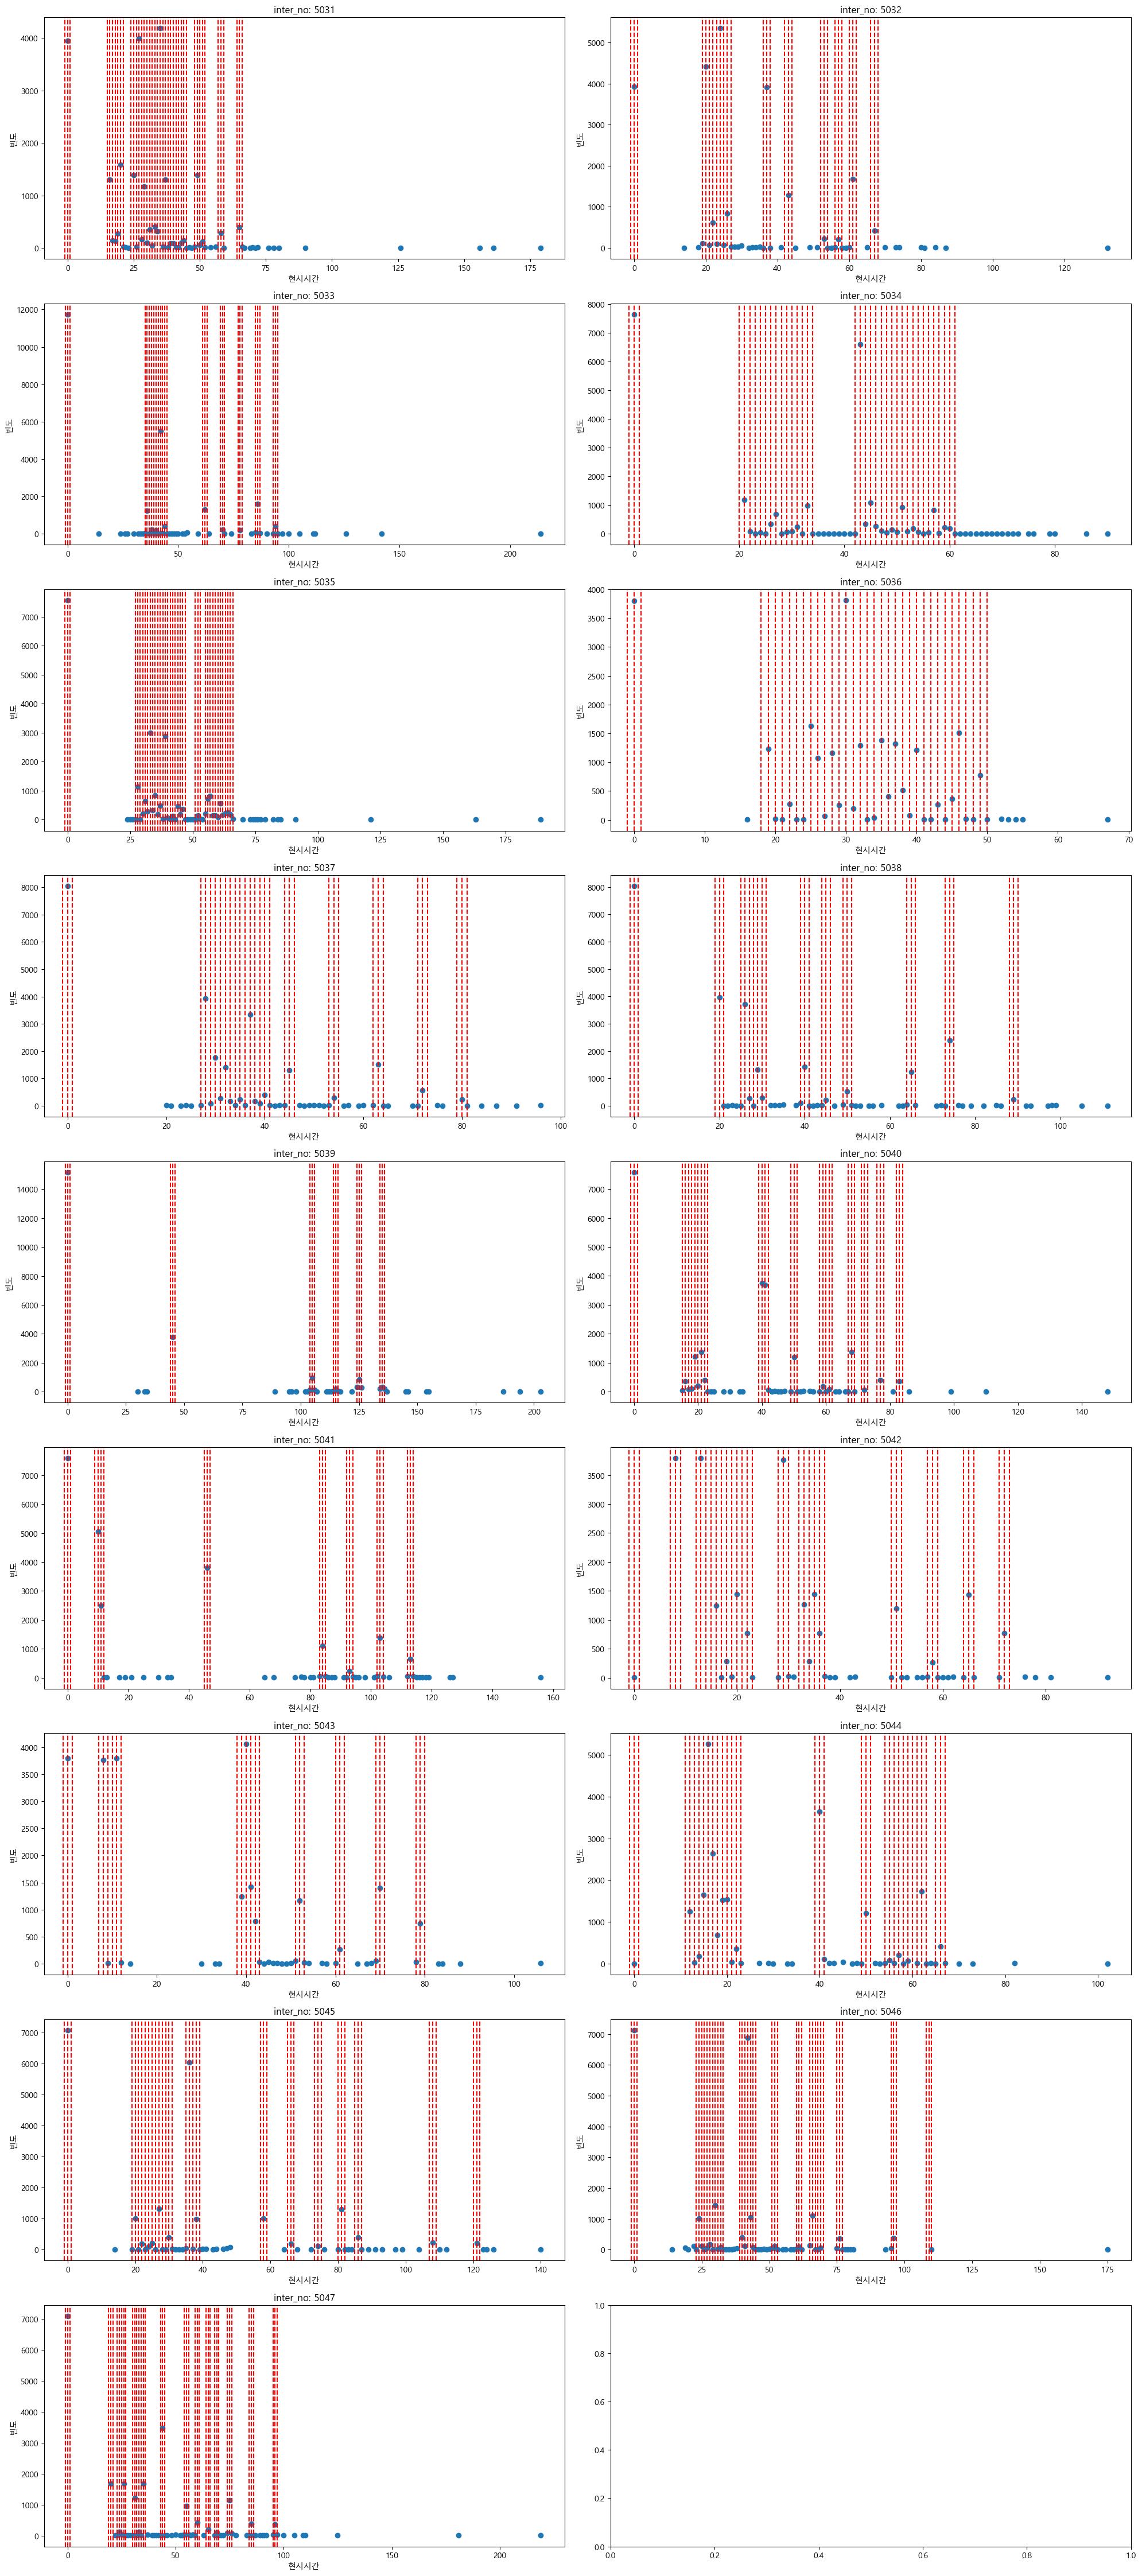

In [7]:
"""
1. 이상치 시각화 (1)

각 교차로ID별로 현시시간의 빈도를 그렸습니다.
예를 들어, 교차로ID가 5031인 경우에 대해서는 현시시간이 35인 경우가 4186번 존재했으므로 (35,4186)에 파란 점이 찍혔습니다.

그림에서 빨간 점선은 이상치가 아닌 정상 현시시간을 가지는 부분을 의미합니다.
시간계획 데이터에서 규정된 현시시간들에서 1의 오차를 허용한 값들은 이상치가 아니라고 정하고 (정상 현시시간), 1보다 큰 오차를 가진다면 이상치라고 정했습니다 (이상 현시시간).
그러니까, 아래 그림에서 빨간 점선에 해당하지 않는 파란 점들이 이상 현시시간 값들과 그 빈도를 나타냅니다.

해석 : 
정상 현시시간들은 높은 빈도를 보이는 경우가 많고, 이상 현시시간들은 낮은 (주로 2회) 빈도를 보입니다.
정상 현시시간들은 convex하지 않고 안에 구멍이 있는 경우가 있습니다.
정상 현시시간에서 많이 벗어나서 그 값이 비이상적으로 커지는 경우도 많이 보입니다.
"""
n_cols = 2
n_rows = len(inter_nos) // n_cols + 1
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 10, n_rows * 5))
for i, inter_no in enumerate(inter_nos):
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col]
    ax.scatter(infos['unique_durations'][inter_no], infos['duration_frequencies'][inter_no])
    for value in infos['accepted_durations'][inter_no]:
        ax.axvline(x=value, color='r', linestyle='--')
    ax.set_title(f'inter_no: {inter_no}')
    ax.set_xlabel('현시시간')
    ax.set_ylabel('빈도')
plt.tight_layout()
plt.show()

In [8]:
k = 2 # context number

# 이상치 dataframe, 이상치를 포함한 주변에 대한 dataframe, 정상 dataframe
infos['outlier_dfs'] = {}
infos['context_dfs'] = {}
infos['context_dfs_list'] = {}
infos['normal_dfs'] = {}
hstr_context = []
hstr_outlier = []
for inter_no in inter_nos:
    df = infos['hstr'][inter_no].sort_values(by='수집날짜시각').reset_index(drop=True)
    outliers = infos['unaccepted_durations'][inter_no]
    ring_columns = [col for col in df.columns if '현시시간' in col]
    outlier_indices = df[df[ring_columns].isin(outliers).any(axis=1)].index
    context_indices = [] # 각 아웃라이어 인덱스에 대해 위아래 네 행의 인덱스를 구합니다.
    context_indices_list = []
    for idx in outlier_indices:
        start_idx = max(idx - k, 0)  # 데이터프레임의 시작을 넘어가지 않도록 합니다.
        end_idx = min(idx + k + 1, len(df))  # 데이터프레임의 끝을 넘어가지 않도록 합니다.
        context_indices.extend(range(start_idx, end_idx))
        context_indices_list.append(list(range(start_idx, end_idx)))
    context_indices = sorted(context_indices)
    normal_indices = sorted(set(df.index) - set(outlier_indices))

    df['전이시간여부'] = False
    for _, row in infos['transition_times'][inter_no].iterrows():
        hour = row.시작시
        minute = row.시작분
        transition_range = ((df['수집날짜시각'].dt.hour==hour) & (df['수집날짜시각'].dt.minute >= minute) & (df['수집날짜시각'].dt.minute <= minute+20))
        df.loc[transition_range, '전이시간여부'] = True

    df['이상치존재'] = False
    df.loc[outlier_indices, '이상치존재'] = True

    infos['outlier_dfs'][inter_no] = df.iloc[outlier_indices].drop_duplicates()
    infos['context_dfs'][inter_no] = df.iloc[context_indices].drop_duplicates()
    infos['context_dfs_list'][inter_no] = []
    for context_indices_ in context_indices_list:
        infos['context_dfs_list'][inter_no].append(df.iloc[context_indices_])
    infos['normal_dfs'][inter_no]  = df.iloc[normal_indices]
    hstr_context.append(infos['context_dfs'][inter_no])
    hstr_outlier.append(infos['outlier_dfs'][inter_no])
hstr_context = pd.concat(hstr_context)
hstr_outlier = pd.concat(hstr_outlier)

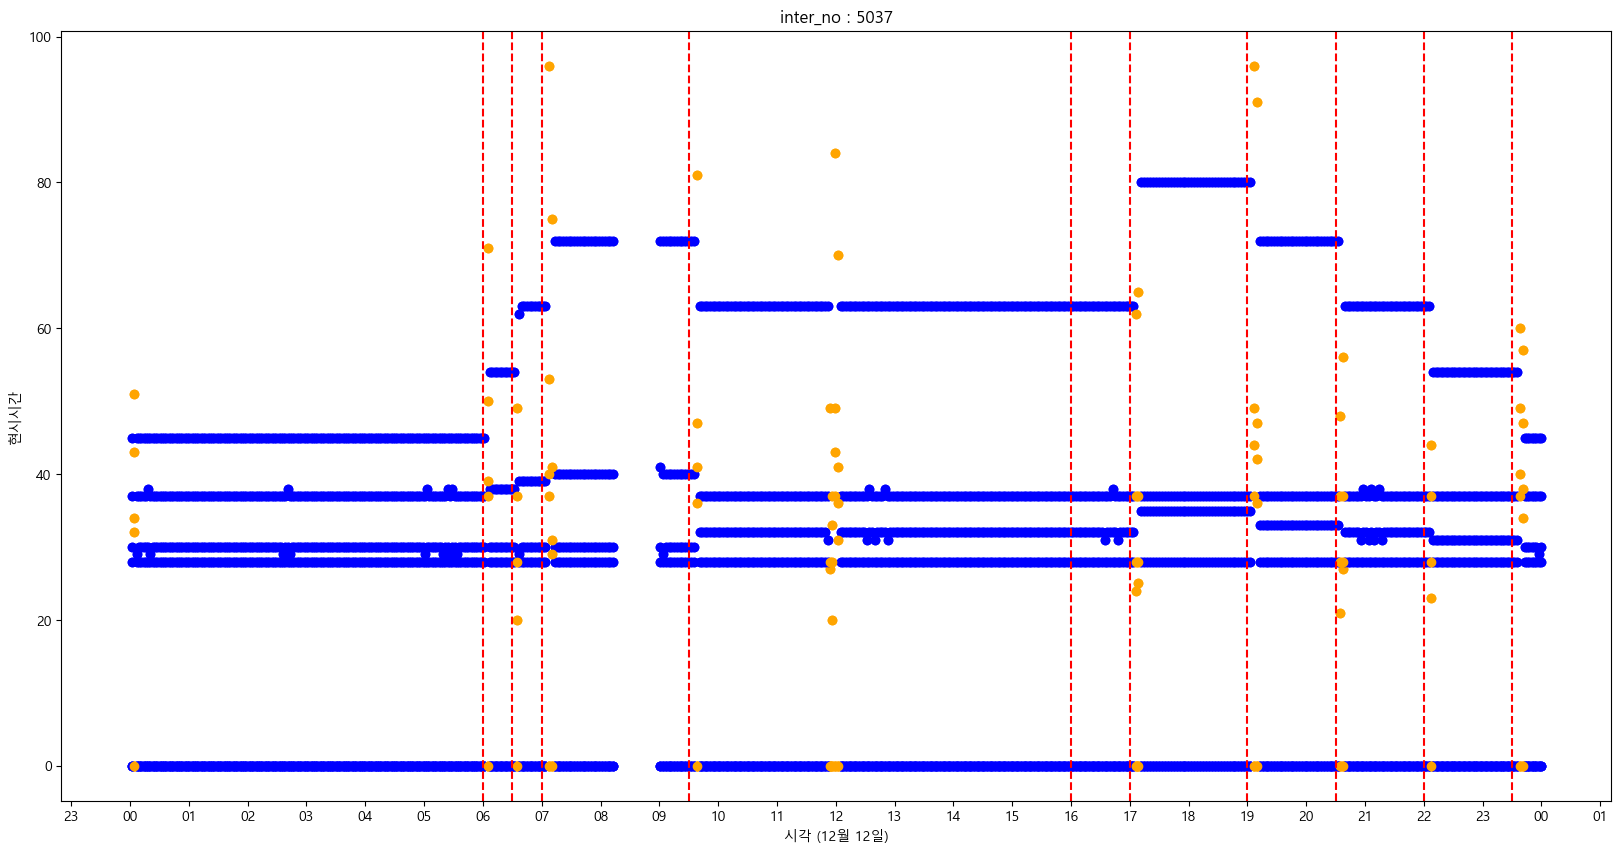

In [9]:
def plot_outliers(inter_no):
    """
    2. 이상치 시각화 (2)

    교차로ID 하나에 대하여 이상치 (이상 현시시간)가 나타나는 순간을 시각화했습니다.
    그림에서 파란 점들은 정상 현시시간이 나타나는 경우이고 노란 점들은 이상 현시시간이 나타나는 경우입니다.
    빨간 점선으로는 전이시각(현시조합이 바뀌는 순간)을 표시했습니다.
    날짜는 12월 12일로 한정지었습니다.

    해석 : (교차로ID = 5037)
    전이시각으로부터 향후 20분간을 전이시간이라고 정의하면, 대부분의 이상 현시시간은 전이시간 내에서 등장합니다.
    전이시간이 아니면서 이상 현시시간이 나타나는 경우가 12시 경에 한 번 있었습니다.
    """
    normal_df = infos['normal_dfs'][inter_no]
    normal_df = normal_df[normal_df.수집날짜시각.dt.day == 12]
    outlier_df = infos['outlier_dfs'][inter_no]
    outlier_df = outlier_df[outlier_df.수집날짜시각.dt.day == 12]
    ring_columns = [col for col in normal_df.columns if '현시시간' in col]
    plt.figure(figsize=(20,10))
    for col in ring_columns:
        plt.scatter(normal_df.수집날짜시각, normal_df[col], color='blue')
        plt.scatter(outlier_df.수집날짜시각, outlier_df[col], color='orange')
    for _, row in infos['transition_times'][inter_no].iterrows():
        start_hour = int(row.시작시)
        start_min = int(row.시작분)
        start_time = datetime(2023, 12, 12, start_hour, start_min)
        plt.axvline(x=start_time, color='r', linestyle='--')
    
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
    ax.set_xlabel('시각 (12월 12일)')
    ax.set_ylabel('현시시간')
    ax.set_title(f'inter_no : {inter_no}')
    plt.show()
plot_outliers(5037)

In [10]:
"""
3. 이상치 관찰

이상 전이시간이 발생하는 경우를 관찰하기 위한 데이터프레임입니다.
이상치가 존재하는 순간을 포함하여 기준으로 앞의 두 순간, 뒤의 두 순간을 포함하여 총 다섯 행을 만듭니다.
이 다섯 행들을 모두 합치되 중복을 제거하여, 이상치가 발생하는 순간과, 그 전후 상황이 어떻게 나타나는지 관찰할 수 있게 합니다.

이상치가 존재하는 경우는 전이시간에 포함되는 경우, 포함되지 않는 경우로 나뉘어서 보아야 할 것이므로
"이상치존재" 열과 "전이시간여부" 행을 명시했습니다.

해석 : (교차로ID = 5037)
첫번째로 이상치가 존재하는 경우 (index = 1)는 2현시시간인 51이 이상 현시시간입니다.
이것은 여타 현시시간과 큰 값의 차이가 나는 것은 아니지만, 정상 현시시간으로 규정한 값에 포함되지 않습니다.
두번째로 이상치가 존재하는 경우 (index = 155)에도 2현시시간인 71이 이상현시시간입니다.
"""

inter_no = 5037
print(f"accepted_durations \n {infos['accepted_durations'][inter_no]}")
print(f"전이시간이 아닌데 이상치가 발생한 경우 \n {sorted(infos['outlier_dfs'][inter_no][infos['outlier_dfs'][inter_no]['전이시간여부']==False].index)}")
for (hour, minute) in infos['offsets'][inter_no]:
    print(f"{hour}:{minute}  {infos['offsets'][inter_no][(hour, minute)]}")
display(infos['context_dfs'][inter_no][:30])

accepted_durations 
 [-1  0  1 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 44 45 46 53 54 55
 62 63 64 71 72 73 79 80 81]
전이시간이 아닌데 이상치가 발생한 경우 
 [1, 267, 268, 269, 270, 537, 823, 824, 1059, 1348, 1349, 1350, 1610, 1903]
6:0  22
6:30  25
7:0  28
9:30  20
16:0  20
17:0  26
19:0  28
20:30  20
22:0  22
23:30  24


현장교차로ID              수집날짜시각  주기시간  옵셋시간  A링1현시시간  A링2현시시간  A링3현시시간  \
0       5037 2023-12-12 00:01:47   140   107       37       45       30   
1       5037 2023-12-12 00:04:27   160   128       43       51       34   
2       5037 2023-12-12 00:06:47   139   127       37       45       29   
3       5037 2023-12-12 00:09:06   140   127       37       45       30   
153     5037 2023-12-12 05:59:06   140   127       37       45       30   
154     5037 2023-12-12 06:01:26   140    87       37       45       30   
155     5037 2023-12-12 06:04:43   197   134       50       71       39   
156     5037 2023-12-12 06:07:13   150   134       38       54       30   
157     5037 2023-12-12 06:09:43   150   134       38       54       30   
165     5037 2023-12-12 06:29:43   150   134       38       54       30   
166     5037 2023-12-12 06:32:13   150    14       38       54       30   
167     5037 2023-12-12 06:34:27   134   148       37       49       20   
168     5037 2023-12-12 06:37:05   158   146       39       62       29   
169     5037 2023-12-12 06:39:45   160   146       39       63       30   
177     5037 2023-12-12 07:01:06   160   146       39       63       30   
178     5037 2023-12-12 07:03:46   160    96       39       63       30   
179     5037 2023-12-12 07:07:32   226   152       53       96       40   
180     5037 2023-12-12 07:10:28   176   158       41       75       31   
181     5037 2023-12-12 07:13:18   170   158       40       72       30   
182     5037 2023-12-12 07:16:08   170   158       40       72       30   
214     5037 2023-12-12 09:32:07   170   158       40       72       30   
215     5037 2023-12-12 09:34:57   170    98       40       72       30   
216     5037 2023-12-12 09:38:22   205   143       47       81       41   
217     5037 2023-12-12 09:41:02   160   143       37       63       32   
218     5037 2023-12-12 09:43:43   160   143       37       63       32   
265     5037 2023-12-12 11:49:04   160   144       37       63       32   
266     5037 2023-12-12 11:51:42   159   142       37       63       31   
267     5037 2023-12-12 11:53:54   104   114        0       49       27   
268     5037 2023-12-12 11:55:52   118    72       37       33       20   
269     5037 2023-12-12 11:59:25   213   125       49       84       43   

     A링4현시시간  A링5현시시간  A링6현시시간  B링1현시시간  B링2현시시간  B링3현시시간  B링4현시시간  B링5현시시간  \
0         28        0        0       37       45       30       28        0   
1         32        0        0       43       51       34       32        0   
2         28        0        0       37       45       29       28        0   
3         28        0        0       37       45       30       28        0   
153       28        0        0       37       45       30       28        0   
154       28        0        0       37       45       30       28        0   
155       37        0        0       50       71       39       37        0   
156       28        0        0       38       54       30       28        0   
157       28        0        0       38       54       30       28        0   
165       28        0        0       38       54       30       28        0   
166       28        0        0       38       54       30       28        0   
167       28        0        0       37       49       20       28        0   
168       28        0        0       39       62       29       28        0   
169       28        0        0       39       63       30       28        0   
177       28        0        0       39       63       30       28        0   
178       28        0        0       39       63       30       28        0   
179       37        0        0       53       96       40       37        0   
180       29        0        0       41       75       31       29        0   
181       28        0        0       40       72       30       28        0   
182       28        0        0       40       72       30       28        0   
214       28        

In [11]:
print([dt for dt in hstr.수집날짜시각 if dt.hour!=23][0])
print([dt for dt in hstr.수집날짜시각 if dt.hour!=23][-1])

2023-12-12 00:00:09
2023-12-15 16:59:54


In [12]:
"""
4. 이상 현시시간 비율 및 전이시간과의 관계
"""

n_outlier = 0
n_outlier_oustide_transition_ranges = 0
for inter_no in inter_nos:
    df = infos['outlier_dfs'][inter_no]
    n_outlier += len(df)
    n_outlier_oustide_transition_ranges += len(df[(df['전이시간여부'] == False) & (df['이상치존재'] == True)])
print(f"전체 현시시간 개수 : {len(hstr)}")
print(f"이상 현시시간 개수 : {n_outlier}")
print(f"전이시간 바깥의 이상 현시시간 개수 : {n_outlier_oustide_transition_ranges}")
print(f"이상 현시시간 비율 : {n_outlier / len(hstr) * 100} %")
print(f"이상 현시시간일 때, 그 이상치가 전이시간 바깥에서 존재하는 비율 : {n_outlier_oustide_transition_ranges / n_outlier * 100} %")

전체 현시시간 개수 : 32466
이상 현시시간 개수 : 940
전이시간 바깥의 이상 현시시간 개수 : 255
이상 현시시간 비율 : 2.895336659890347 %
이상 현시시간일 때, 그 이상치가 전이시간 바깥에서 존재하는 비율 : 27.127659574468083 %


In [13]:
"""
5. 전이시간 바깥에서 발생하는 이상현시시간 관찰

이상치존재가 True이고 전이시간여부가 False인 경우에 대하여 앞의 두 번 뒤의 두 번을 포함해 관찰합니다.
"""

infos['context_dfs_outside_the_transition_ranges'] = {}
infos['outlier_lists'] = {}
infos['outliers'] = []
for inter_no in inter_nos:
    dfs = infos['context_dfs_list'][inter_no]
    dfs = [dfs[i] for i in range(len(dfs)) if ~dfs[i].iloc[2]['전이시간여부']]
    infos['context_dfs_outside_the_transition_ranges'][inter_no] = pd.concat(dfs).drop_duplicates()

    df = infos['outlier_dfs'][inter_no].iloc[:,4:-2]
    is_outlier = df.isin(infos['unaccepted_durations'][inter_no])
    temp = df[is_outlier].values.flatten()
    temp = np.unique(temp[pd.notna(temp)])
    infos['outlier_lists'][inter_no] = np.unique(temp[pd.notna(temp)])
    infos['outliers'].extend(infos['outlier_lists'][inter_no])
infos['context_dfs_outside_the_transition_ranges'][5031]

현장교차로ID              수집날짜시각  주기시간  옵셋시간  A링1현시시간  A링2현시시간  A링3현시시간  \
776      5031 2023-12-13 10:31:40   160   140       49       20       27   
777      5031 2023-12-13 10:34:20   160   140       49       20       27   
778      5031 2023-12-13 10:39:07    31   107       49       20       27   
779      5031 2023-12-13 10:41:27   140    87       37       16       27   
780      5031 2023-12-13 10:45:00   213   140       69       31       31   
781      5031 2023-12-13 10:47:40   160   140       49       20       27   
782      5031 2023-12-13 10:50:20   160   140       49       20       27   
910      5031 2023-12-13 18:02:38   180   159       65       20       27   
911      5031 2023-12-13 18:05:38   180   159       65       20       27   
912      5031 2023-12-13 18:10:47    52   107       65       20       27   
913      5031 2023-12-13 18:13:07   140    67       37       16       27   
914      5031 2023-12-13 18:17:06   239   126       90       31       31   
915      5031 2023-12-13 18:20:39   213   159       78       25       31   
916      5031 2023-12-13 18:23:39   180   160       65       20       27   
917      5031 2023-12-13 18:26:38   179   159       65       20       27   
1031     5031 2023-12-13 23:45:40   140     0       37       16       27   
1032     5031 2023-12-13 23:48:00   140     0       37       16       27   
1033     5031 2023-12-13 23:52:43    26     3      179       16       27   
1034     5031 2023-12-13 23:55:02   140     2       37       16       27   
1035     5031 2023-12-13 23:57:22   140     2       37       16       27   
1761     5031 2023-12-15 07:14:41   180   161       49       35       27   
1762     5031 2023-12-15 07:17:41   180   161       49       35       27   
1763     5031 2023-12-15 07:21:58     1    58      126       35       27   
1764     5031 2023-12-15 07:24:18   140    19       37       16       27   
1765     5031 2023-12-15 07:26:49   151   169       39       25       27   
1766     5031 2023-12-15 07:29:41   172   161       47       32       27   
1767     5031 2023-12-15 07:32:41   180   161       49       35       27   
1768     5031 2023-12-15 07:35:41   180   161       49       35       27   

      A링4현시시간  A링5현시시간  A링6현시시간  B링1현시시간  B링2현시시간  B링3현시시간  B링4현시시간  B링5현시시간  \
776        29       35        0       49       20       27       29       35   
777        29       35        0       49       20       27       29       35   
778       156       35        0       49       20       27      156       35   
779        25       35        0       37       16       27       25       35   
780        43       39        0       69       31       31       43       39   
781        29       35        0       49       20       27       29       35   
782        29       35        0       49       20       27       29       35   
910        33       35        0       65       20       27       33       35   
911        33       35        0       65       20       27       33       35   
912       161       35        0       65       20       27      161       35   
913        25       35        0       37       16       27       25       35   
914        48       39        0       90       31       31       48       39   
915        40       39        0       78       25       31       40       39   
916        33       35        0       65       20       27       33       35   
917        32       35        0       65       20       27       32       35   
1031       25       35        0       37       16       27       25       35   
1032       25       35        0       37       16       27       25       35   
1033       25       35        0      179       16       27       25       35   
1034       25       35        0       37       16       27       25       35   
1035       25       35        0       37       16       27       25       35   
1761       34       35        0       49       35       27       34       35   
1762       34       35        0       49 

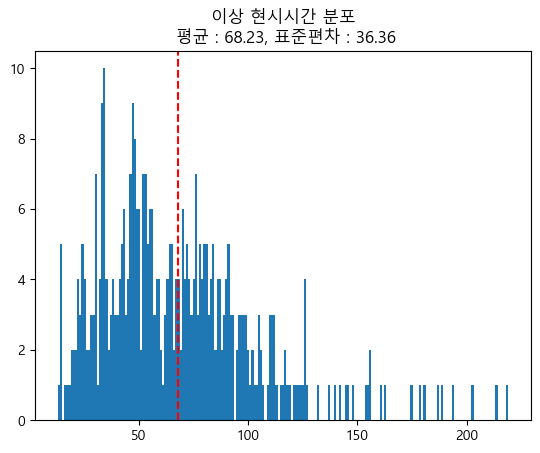

임계값 = 75초 -> 소실비율 = 36.93 %
임계값 = 90초 -> 소실비율 = 21.86 %
임계값 = 120초 -> 소실비율 = 8.04 %
임계값 = 180초 -> 소실비율 = 1.76 %
임계값 = 240초 -> 소실비율 = 0.00 %


In [14]:
"""
6. 이상 현시시간 분포

이상 현시시간은 그림에서 나오는 것과 같은 분포를 가집니다.
정규분포는 아니고 카이제곱분포처럼 생겼습니다.

신호이력을 수집하는 시간간격(threshold, 임계값)을 바꿔가면서 얼마만큼의 비율의 이상 현시시간이 소실되는지를 관찰했습니다.
임계값이 4분이면 아무런 소실이 없습니다.
그밖에 임계값을 2분 혹은 3분으로 하면서 8.04 %, 1.76 % 의 소실비율을 용인하는 것도 가능합니다.
"""
outliers = np.array(infos['outliers'])
Unique_values, Frequency = np.unique(outliers, return_counts=True)
mean = "{:.2f}".format(outliers.mean())
std  = "{:.2f}".format(outliers.std())
# plt.figure(figsize=(20,10))
plt.hist(outliers, bins=int(outliers.max() - outliers.min() + 1))
plt.axvline(x=float(mean), color='r', linestyle='--')
plt.title(f'이상 현시시간 분포\n 평균 : {mean}, 표준편차 : {std}')
plt.show()
plt.scatter(Unique_values, Frequency)
plt.axvline(x=float(mean), color='r', linestyle='--')
plt.title(f'이상 현시시간 분포\n 평균 : {mean}, 표준편차 : {std}')
plt.close()
thresholds = [75, 90, 120, 180, 240]
for threshold in thresholds:
    n_greater = [outlier for outlier in outliers if outlier > threshold]
    print(f"임계값 = {threshold}초 -> 소실비율 = " + "{:.2f}".format(len(n_greater)/len(outliers)*100) + " %")
    mean = "{:.2f}".format(outliers.mean())

In [15]:
# k = 2 # context number

# # 이상치 dataframe, 이상치를 포함한 주변에 대한 dataframe, 정상 dataframe
# infos['outlier_dfs'] = {}
# infos['context_dfs'] = {}
# infos['context_dfs_list'] = {}
# infos['normal_dfs'] = {}
# hstr_context = []
# hstr_outlier = []
# for inter_no in inter_nos:
#     df = infos['hstr'][inter_no].sort_values(by='수집날짜시각').reset_index(drop=True)
#     outliers = infos['unaccepted_durations'][inter_no]
#     ring_columns = [col for col in df.columns if '현시시간' in col]
#     outlier_indices = df[df[ring_columns].isin(outliers).any(axis=1)].index
#     context_indices = [] # 각 아웃라이어 인덱스에 대해 위아래 네 행의 인덱스를 구합니다.
#     context_indices_list = []
#     for idx in outlier_indices:
#         start_idx = max(idx - k, 0)  # 데이터프레임의 시작을 넘어가지 않도록 합니다.
#         end_idx = min(idx + k + 1, len(df))  # 데이터프레임의 끝을 넘어가지 않도록 합니다.
#         context_indices.extend(range(start_idx, end_idx))
#         context_indices_list.append(list(range(start_idx, end_idx)))
#     context_indices = sorted(context_indices)
#     normal_indices = sorted(set(df.index) - set(outlier_indices))

#     df['전이시간여부'] = False
#     for _, row in infos['transition_times'][inter_no].iterrows():
#         hour = row.시작시
#         minute = row.시작분
#         transition_range = ((df['수집날짜시각'].dt.hour==hour) & (df['수집날짜시각'].dt.minute >= minute) & (df['수집날짜시각'].dt.minute <= minute+20))
#         df.loc[transition_range, '전이시간여부'] = True

#     df['이상치존재'] = False
#     df.loc[outlier_indices, '이상치존재'] = True


In [16]:
k = 3 # context number
max_cycle = timeplans['주기시간'].max()
infos['missing_df'] = {}

for inter_no in inter_nos:
    df = infos['hstr'][inter_no].sort_values(by='수집날짜시각').reset_index(drop=True)
    df['시간차이'] = df['수집날짜시각'].diff().dt.total_seconds()
    df.dropna(inplace=True)
    df = df.reset_index(drop=True)
    missed_indices = df[df['시간차이'] > max_cycle + 10].index
    df['결측여부'] = False
    df.loc[missed_indices, '결측여부'] = True

    df['전이시간여부'] = False
    for _, row in infos['transition_times'][inter_no].iterrows():
        hour = row.시작시
        minute = row.시작분
        transition_range = ((df['수집날짜시각'].dt.hour==hour) & (df['수집날짜시각'].dt.minute >= minute) & (df['수집날짜시각'].dt.minute <= minute+20))
        df.loc[transition_range, '전이시간여부'] = True

    ring_columns = [col for col in df.columns if '현시시간' in col]
    df['주기일치'] = (df['주기시간'].astype(float) == df[ring_columns].sum(axis=1)/2)

    outliers = infos['unaccepted_durations'][inter_no]
    df['이상치존재'] = False
    df.loc[outlier_indices, '이상치존재'] = True

    infos['missing_df'][inter_no] = missed_indices
    context_indices = []
    for idx in missed_indices:
        start_idx = max(idx - k, 0)  # 데이터프레임의 시작을 넘어가지 않도록 합니다.
        end_idx = min(idx + k + 1, len(df))  # 데이터프레임의 끝을 넘어가지 않도록 합니다.
        context_indices.extend(range(start_idx, end_idx))
    infos['missing_df'][inter_no] = df.iloc[context_indices].drop_duplicates()
# for inter_no in inter_nos:
#     print(inter_no)
#     with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#         display(infos['missing_df'][inter_no])

In [30]:
infos['missing_dfs'] = {}
for inter_no in inter_nos:
    DF = infos['missing_df'][inter_no]
    dfs = []
    temp_indices = []

    for i in DF.index:
        if not temp_indices or i == temp_indices[-1] + 1:  # 첫 인덱스이거나 이전 인덱스와 연속적인 경우
            temp_indices.append(i)
        else:  # 연속이 끊긴 경우
            dfs.append(DF.loc[temp_indices])  # 현재까지의 임시 데이터프레임을 결과 리스트에 추가
            temp_indices = [i]  # 새로운 임시 데이터프레임 시작

    if temp_indices:
        dfs.append(DF.loc[temp_indices])
    infos['missing_dfs'][inter_no] = dfs

In [23]:
inter_no = 5031
j = 1
cycle = 180
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(infos['missing_dfs'][inter_no][j])
sum_of_durations = infos['missing_dfs'][inter_no][j].시간차이.sum()
print(sum_of_durations)
print(sum_of_durations % cycle)
print(infos['cycles'][inter_no])

현장교차로ID              수집날짜시각  주기시간  옵셋시간  A링1현시시간  A링2현시시간  A링3현시시간  \
197     5031 2023-12-12 08:05:40   180   161       49       35       27   
198     5031 2023-12-12 08:08:41   180   161       49       35       27   
199     5031 2023-12-12 08:11:41   180   161       49       35       27   
200     5031 2023-12-12 09:02:41   180   161       49       35       27   
201     5031 2023-12-12 09:05:41   180   161       49       35       27   
202     5031 2023-12-12 09:08:41   180   161       49       35       27   
203     5031 2023-12-12 09:11:41   180   161       49       35       27   

     A링4현시시간  A링5현시시간  A링6현시시간  B링1현시시간  B링2현시시간  B링3현시시간  B링4현시시간  B링5현시시간  \
197       34       35        0       49       35       27       34       35   
198       34       35        0       49       35       27       34       35   
199       34       35        0       49       35       27       34       35   
200       34       35        0       49       35       27       34       35   
201       34       35        0       49       35       27       34       35   
202       34       35        0       49       35       27       34       35   
203       34       35        0       49       35       27       34       35   

     B링6현시시간    시간차이   결측여부  전이시간여부  주기일치  이상치존재  
197        0   180.0  False   False  True  False  
198        0   181.0  False   False  True  False  
199        0   180.0  False   False  True  False  
200        0  3060.0   True   False  True  False  
201        0   180.0  False   False  True  False  
202        0   180.0  False   False  True  False  
203        0   180.0  False   False  True  False

4141.0
1.0
{(6, 0): 150, (6, 30): 160, (7, 0): 180, (9, 30): 160, (16, 0): 170, (17, 0): 180, (20, 30): 170, (21, 30): 160, (22, 30): 150, (23, 30): 140}


In [26]:
inter_no = 5031
j = 3
cycle = 160
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(infos['missing_dfs'][inter_no][j])
sum_of_durations = infos['missing_dfs'][inter_no][j].시간차이.sum()
print(sum_of_durations)
print(sum_of_durations % cycle)
print(infos['cycles'][inter_no])

현장교차로ID              수집날짜시각  주기시간  옵셋시간  A링1현시시간  A링2현시시간  A링3현시시간  \
774     5031 2023-12-13 10:29:00   160   140       49       20       27   
775     5031 2023-12-13 10:31:40   160   140       49       20       27   
776     5031 2023-12-13 10:34:20   160   140       49       20       27   
777     5031 2023-12-13 10:39:07    31   107       49       20       27   
778     5031 2023-12-13 10:41:27   140    87       37       16       27   
779     5031 2023-12-13 10:45:00   213   140       69       31       31   
780     5031 2023-12-13 10:47:40   160   140       49       20       27   

     A링4현시시간  A링5현시시간  A링6현시시간  B링1현시시간  B링2현시시간  B링3현시시간  B링4현시시간  B링5현시시간  \
774       29       35        0       49       20       27       29       35   
775       29       35        0       49       20       27       29       35   
776       29       35        0       49       20       27       29       35   
777      156       35        0       49       20       27      156       35   
778       25       35        0       37       16       27       25       35   
779       43       39        0       69       31       31       43       39   
780       29       35        0       49       20       27       29       35   

     B링6현시시간   시간차이   결측여부  전이시간여부   주기일치  이상치존재  
774        0  160.0  False   False   True  False  
775        0  160.0  False   False   True  False  
776        0  160.0  False   False   True  False  
777        0  287.0   True   False  False  False  
778        0  140.0  False   False   True  False  
779        0  213.0  False   False   True  False  
780        0  160.0  False   False   True  False

1280.0
0.0
{(6, 0): 150, (6, 30): 160, (7, 0): 180, (9, 30): 160, (16, 0): 170, (17, 0): 180, (20, 30): 170, (21, 30): 160, (22, 30): 150, (23, 30): 140}


In [29]:
inter_no = 5031
j = 5
cycle = 180
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(infos['missing_dfs'][inter_no][j])
sum_of_durations = infos['missing_dfs'][inter_no][j].시간차이.sum()
print(sum_of_durations)
print(sum_of_durations % cycle)
print(infos['cycles'][inter_no])

현장교차로ID              수집날짜시각  주기시간  옵셋시간  A링1현시시간  A링2현시시간  A링3현시시간  \
908     5031 2023-12-13 17:59:38   180   159       65       20       27   
909     5031 2023-12-13 18:02:38   180   159       65       20       27   
910     5031 2023-12-13 18:05:38   180   159       65       20       27   
911     5031 2023-12-13 18:10:47    52   107       65       20       27   
912     5031 2023-12-13 18:13:07   140    67       37       16       27   
913     5031 2023-12-13 18:17:06   239   126       90       31       31   
914     5031 2023-12-13 18:20:39   213   159       78       25       31   
915     5031 2023-12-13 18:23:39   180   160       65       20       27   
916     5031 2023-12-13 18:26:38   179   159       65       20       27   

     A링4현시시간  A링5현시시간  A링6현시시간  B링1현시시간  B링2현시시간  B링3현시시간  B링4현시시간  B링5현시시간  \
908       33       35        0       65       20       27       33       35   
909       33       35        0       65       20       27       33       35   
910       33       35        0       65       20       27       33       35   
911      161       35        0       65       20       27      161       35   
912       25       35        0       37       16       27       25       35   
913       48       39        0       90       31       31       48       39   
914       40       39        0       78       25       31       40       39   
915       33       35        0       65       20       27       33       35   
916       32       35        0       65       20       27       32       35   

     B링6현시시간   시간차이   결측여부  전이시간여부   주기일치  이상치존재  
908        0  180.0  False   False   True  False  
909        0  180.0  False   False   True  False  
910        0  180.0  False   False   True   True  
911        0  309.0   True   False  False   True  
912        0  140.0  False   False   True   True  
913        0  239.0   True   False   True  False  
914        0  213.0  False   False   True  False  
915        0  180.0  False   False   True  False  
916        0  179.0  False   False   True  False

1800.0
0.0
{(6, 0): 150, (6, 30): 160, (7, 0): 180, (9, 30): 160, (16, 0): 170, (17, 0): 180, (20, 30): 170, (21, 30): 160, (22, 30): 150, (23, 30): 140}


In [36]:
inter_no = 5032
j = 0
cycle = 170
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(infos['missing_dfs'][inter_no][j])
sum_of_durations = infos['missing_dfs'][inter_no][j].시간차이.sum()
print(sum_of_durations)
print(sum_of_durations % cycle)
print(infos['cycles'][inter_no])

현장교차로ID              수집날짜시각  주기시간  옵셋시간  A링1현시시간  A링2현시시간  A링3현시시간  \
200     5032 2023-12-12 08:08:15   170    55       24       61       24   
201     5032 2023-12-12 08:11:05   170    55       24       61       24   
202     5032 2023-12-12 08:13:55   170    55       24       61       24   
203     5032 2023-12-12 09:02:04   169    55       24       61       24   
204     5032 2023-12-12 09:04:54   170    55       24       61       24   
205     5032 2023-12-12 09:07:44   170    55       24       61       24   
206     5032 2023-12-12 09:10:34   170    55       24       61       24   

     A링4현시시간  A링5현시시간  A링6현시시간  B링1현시시간  B링2현시시간  B링3현시시간  B링4현시시간  B링5현시시간  \
200       37       24        0       24       61       24       37       24   
201       37       24        0       24       61       24       37       24   
202       37       24        0       24       61       24       37       24   
203       37       23        0       24       61       24       37       23   
204       37       24        0       24       61       24       37       24   
205       37       24        0       24       61       24       37       24   
206       37       24        0       24       61       24       37       24   

     B링6현시시간    시간차이   결측여부  전이시간여부  주기일치  이상치존재  
200        0   170.0  False   False  True  False  
201        0   170.0  False   False  True  False  
202        0   170.0  False   False  True  False  
203        0  2889.0   True   False  True  False  
204        0   170.0  False   False  True  False  
205        0   170.0  False   False  True  False  
206        0   170.0  False   False  True  False

3909.0
169.0
{(6, 0): 150, (6, 30): 160, (7, 0): 170, (9, 30): 170, (16, 0): 170, (17, 0): 180, (20, 30): 170, (21, 30): 160, (22, 30): 150, (23, 30): 140}


In [41]:
inter_no = 5032
j = 1
cycle = 140
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(infos['missing_dfs'][inter_no][j])
sum_of_durations = infos['missing_dfs'][inter_no][j].시간차이.sum()
print(sum_of_durations)
print(sum_of_durations % cycle)
print(infos['cycles'][inter_no])

현장교차로ID              수집날짜시각  주기시간  옵셋시간  A링1현시시간  A링2현시시간  A링3현시시간  \
653     5032 2023-12-13 05:09:01   140    61       20       43       20   
654     5032 2023-12-13 05:11:20   139    60       20       43       20   
655     5032 2023-12-13 05:13:40   141    60       20       43       20   
656     5032 2023-12-13 05:17:53   252    32      132       43       20   
657     5032 2023-12-13 05:19:50   117     9       18       24       19   
658     5032 2023-12-13 05:22:55   186    55       30       60       30   
659     5032 2023-12-13 05:25:20   145    60       21       45       21   

     A링4현시시간  A링5현시시간  A링6현시시간  B링1현시시간  B링2현시시간  B링3현시시간  B링4현시시간  B링5현시시간  \
653       37       20        0       20       43       20       37       20   
654       37       19        0       20       43       20       37       19   
655       38       20        0       20       43       20       38       20   
656       37       20        0      132       43       20       37       20   
657       37       19        0       18       24       19       37       19   
658       37       29        0       30       60       30       37       29   
659       37       21        0       21       45       21       37       21   

     B링6현시시간   시간차이   결측여부  전이시간여부  주기일치  이상치존재  
653        0  140.0  False   False  True  False  
654        0  139.0  False   False  True  False  
655        0  140.0  False   False  True  False  
656        0  253.0   True   False  True  False  
657        0  117.0  False   False  True  False  
658        0  185.0  False   False  True  False  
659        0  145.0  False   False  True  False

1119.0
139.0
{(6, 0): 150, (6, 30): 160, (7, 0): 170, (9, 30): 170, (16, 0): 170, (17, 0): 180, (20, 30): 170, (21, 30): 160, (22, 30): 150, (23, 30): 140}


In [46]:
inter_no = 5033
j = 0
cycle = 170
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(infos['missing_dfs'][inter_no][j])
sum_of_durations = infos['missing_dfs'][inter_no][j].시간차이.sum()
print(sum_of_durations)
print(sum_of_durations % cycle)
print(infos['cycles'][inter_no])

현장교차로ID              수집날짜시각  주기시간  옵셋시간  A링1현시시간  A링2현시시간  A링3현시시간  \
200     5033 2023-12-12 08:07:51   170    32       42       86       42   
201     5033 2023-12-12 08:10:41   170    32       42       86       42   
202     5033 2023-12-12 08:13:32   170    32       42       86       42   
203     5033 2023-12-12 09:01:42   170    32       42       86       42   
204     5033 2023-12-12 09:04:32   170    32       42       86       42   
205     5033 2023-12-12 09:07:22   170    32       42       86       42   
206     5033 2023-12-12 09:10:12   170    32       42       86       42   

     A링4현시시간  A링5현시시간  A링6현시시간  B링1현시시간  B링2현시시간  B링3현시시간  B링4현시시간  B링5현시시간  \
200        0        0        0       42       86       42        0        0   
201        0        0        0       42       86       42        0        0   
202        0        0        0       42       86       42        0        0   
203        0        0        0       42       86       42        0        0   
204        0        0        0       42       86       42        0        0   
205        0        0        0       42       86       42        0        0   
206        0        0        0       42       86       42        0        0   

     B링6현시시간    시간차이   결측여부  전이시간여부  주기일치  이상치존재  
200        0   170.0  False   False  True  False  
201        0   170.0  False   False  True  False  
202        0   171.0  False   False  True  False  
203        0  2890.0   True   False  True  False  
204        0   170.0  False   False  True  False  
205        0   170.0  False   False  True  False  
206        0   170.0  False   False  True  False

3911.0
1.0
{(6, 0): 150, (6, 30): 160, (7, 0): 170, (9, 30): 170, (16, 0): 170, (17, 0): 180, (20, 30): 170, (21, 30): 160, (22, 30): 150, (23, 30): 140}


In [49]:
inter_no = 5033
j = 2
cycle = 180
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(infos['missing_dfs'][inter_no][j])
sum_of_durations = infos['missing_dfs'][inter_no][j].시간차이.sum()
print(sum_of_durations)
print(sum_of_durations % cycle)
print(infos['cycles'][inter_no])

현장교차로ID              수집날짜시각  주기시간  옵셋시간  A링1현시시간  A링2현시시간  A링3현시시간  \
891     5033 2023-12-13 17:30:43   180    44       42       94       44   
892     5033 2023-12-13 17:33:43   180    44       42       94       44   
893     5033 2023-12-13 17:36:43   180    44       42       94       44   
894     5033 2023-12-13 17:42:34    94    34       42       94      214   
895     5033 2023-12-13 17:44:33   119   153       42       53       24   
896     5033 2023-12-13 17:48:32   239    32       54      126       59   
897     5033 2023-12-13 17:51:44   192    44       45      100       47   
898     5033 2023-12-13 17:54:44   180    44       42       94       44   
899     5033 2023-12-13 17:57:44   180    44       42       94       44   

     A링4현시시간  A링5현시시간  A링6현시시간  B링1현시시간  B링2현시시간  B링3현시시간  B링4현시시간  B링5현시시간  \
891        0        0        0       42       94       44        0        0   
892        0        0        0       42       94       44        0        0   
893        0        0        0       42       94       44        0        0   
894        0        0        0       42       94      214        0        0   
895        0        0        0       42       53       24        0        0   
896        0        0        0       54      126       59        0        0   
897        0        0        0       45      100       47        0        0   
898        0        0        0       42       94       44        0        0   
899        0        0        0       42       94       44        0        0   

     B링6현시시간   시간차이   결측여부  전이시간여부   주기일치  이상치존재  
891        0  180.0  False   False   True  False  
892        0  180.0  False   False   True  False  
893        0  180.0  False   False   True  False  
894        0  351.0   True   False  False  False  
895        0  119.0  False   False   True  False  
896        0  239.0   True   False   True  False  
897        0  192.0  False   False   True  False  
898        0  180.0  False   False   True  False  
899        0  180.0  False   False   True  False

1801.0
1.0
{(6, 0): 150, (6, 30): 160, (7, 0): 170, (9, 30): 170, (16, 0): 170, (17, 0): 180, (20, 30): 170, (21, 30): 160, (22, 30): 150, (23, 30): 140}


In [53]:
inter_no = 5034
j = 0
cycle = 180
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(infos['missing_dfs'][inter_no][j])
sum_of_durations = infos['missing_dfs'][inter_no][j].시간차이.sum()
print(sum_of_durations)
print(sum_of_durations % cycle)
print(infos['cycles'][inter_no])

현장교차로ID              수집날짜시각  주기시간  옵셋시간  A링1현시시간  A링2현시시간  A링3현시시간  \
186     5034 2023-12-12 08:05:37   180   158       53       33       51   
187     5034 2023-12-12 08:08:37   180   157       53       33       51   
188     5034 2023-12-12 08:11:38   181   159       53       33       52   
189     5034 2023-12-12 09:02:37   180   158       53       33       51   
190     5034 2023-12-12 09:05:37   180   158       53       33       51   
191     5034 2023-12-12 09:08:38   180   158       53       33       51   
192     5034 2023-12-12 09:11:38   180   158       53       33       51   

     A링4현시시간  A링5현시시간  A링6현시시간  B링1현시시간  B링2현시시간  B링3현시시간  B링4현시시간  B링5현시시간  \
186       43        0        0       26       60       51       43        0   
187       43        0        0       26       60       51       43        0   
188       43        0        0       26       60       52       43        0   
189       43        0        0       26       60       51       43        0   
190       43        0        0       26       60       51       43        0   
191       43        0        0       26       60       51       43        0   
192       43        0        0       26       60       51       43        0   

     B링6현시시간    시간차이   결측여부  전이시간여부  주기일치  이상치존재  
186        0   180.0  False   False  True  False  
187        0   180.0  False   False  True  False  
188        0   181.0  False   False  True  False  
189        0  3059.0   True   False  True  False  
190        0   180.0  False   False  True  False  
191        0   181.0  False   False  True  False  
192        0   180.0  False   False  True  False

4141.0
1.0
{(5, 30): 160, (6, 30): 170, (7, 0): 180, (9, 30): 170, (17, 0): 180, (21, 0): 170, (22, 0): 160, (23, 30): 150}


In [56]:
inter_no = 5034
j = 1
cycle = 180
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(infos['missing_dfs'][inter_no][j])
sum_of_durations = infos['missing_dfs'][inter_no][j].시간차이.sum()
print(sum_of_durations)
print(sum_of_durations % cycle)
print(infos['cycles'][inter_no])

현장교차로ID              수집날짜시각  주기시간  옵셋시간  A링1현시시간  A링2현시시간  A링3현시시간  \
384     5034 2023-12-12 18:19:05    57    65       57        0        0   
385     5034 2023-12-12 18:22:05   180    65       57       33       45   
386     5034 2023-12-12 18:24:35   150    35       43       21       43   
387     5034 2023-12-12 18:28:35   240    95       76       44       60   
388     5034 2023-12-12 18:32:35   240   155       76       44       60   
389     5034 2023-12-12 18:35:39   184   159       58       34       46   
390     5034 2023-12-12 18:38:39   180   159       57       33       45   
391     5034 2023-12-12 18:41:39   180   159       57       33       45   

     A링4현시시간  A링5현시시간  A링6현시시간  B링1현시시간  B링2현시시간  B링3현시시간  B링4현시시간  B링5현시시간  \
384        0        0        0       31        0        0        0        0   
385       45        0        0       31       59       45       45        0   
386       43        0        0       21       43       43       43        0   
387       60        0        0       41       79       60       60        0   
388       60        0        0       41       79       60       60        0   
389       46        0        0       32       60       46       46        0   
390       45        0        0       31       59       45       45        0   
391       45        0        0       31       59       45       45        0   

     B링6현시시간   시간차이   결측여부  전이시간여부   주기일치  이상치존재  
384        0   88.0  False   False  False  False  
385        0  180.0  False   False   True  False  
386        0  150.0  False   False   True  False  
387        0  240.0   True   False   True  False  
388        0  240.0   True   False   True  False  
389        0  184.0  False   False   True  False  
390        0  180.0  False   False   True  False  
391        0  180.0  False   False   True  False

1442.0
2.0
{(5, 30): 160, (6, 30): 170, (7, 0): 180, (9, 30): 170, (17, 0): 180, (21, 0): 170, (22, 0): 160, (23, 30): 150}


In [57]:
inter_no = 5034
j = 2
cycle = 180
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(infos['missing_dfs'][inter_no][j])
sum_of_durations = infos['missing_dfs'][inter_no][j].시간차이.sum()
print(sum_of_durations)
print(sum_of_durations % cycle)
print(infos['cycles'][inter_no])

현장교차로ID              수집날짜시각  주기시간  옵셋시간  A링1현시시간  A링2현시시간  A링3현시시간  \
705     5034 2023-12-13 08:47:40   180   160       53       33       51   
706     5034 2023-12-13 08:50:40   180   160       53       33       51   
707     5034 2023-12-13 08:53:40   180   160       53       33       51   
708     5034 2023-12-13 08:59:12    46   132        0        0        0   
709     5034 2023-12-13 09:02:40   208   160       61       39       59   
710     5034 2023-12-13 09:05:40   180   160       53       33       51   
711     5034 2023-12-13 09:08:40   180   160       53       33       51   

     A링4현시시간  A링5현시시간  A링6현시시간  B링1현시시간  B링2현시시간  B링3현시시간  B링4현시시간  B링5현시시간  \
705       43        0        0       26       60       51       43        0   
706       43        0        0       26       60       51       43        0   
707       43        0        0       26       60       51       43        0   
708       46        0        0        0        0        0       46        0   
709       49        0        0       30       70       59       49        0   
710       43        0        0       26       60       51       43        0   
711       43        0        0       26       60       51       43        0   

     B링6현시시간   시간차이   결측여부  전이시간여부  주기일치  이상치존재  
705        0  180.0  False   False  True  False  
706        0  180.0  False   False  True  False  
707        0  180.0  False   False  True  False  
708        0  332.0   True   False  True  False  
709        0  208.0  False   False  True  False  
710        0  180.0  False   False  True  False  
711        0  180.0  False   False  True  False

1440.0
0.0
{(5, 30): 160, (6, 30): 170, (7, 0): 180, (9, 30): 170, (17, 0): 180, (21, 0): 170, (22, 0): 160, (23, 30): 150}


In [59]:
inter_no = 5034
j = 3
cycle = 170
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(infos['missing_dfs'][inter_no][j])
sum_of_durations = infos['missing_dfs'][inter_no][j].시간차이.sum()
print(sum_of_durations)
print(sum_of_durations % cycle)
print(infos['cycles'][inter_no])

현장교차로ID              수집날짜시각  주기시간  옵셋시간  A링1현시시간  A링2현시시간  A링3현시시간  \
825     5034 2023-12-13 14:32:27   170   157       51       33       43   
826     5034 2023-12-13 14:35:17   170   157       51       33       43   
827     5034 2023-12-13 14:38:07   170   157       51       33       43   
828     5034 2023-12-13 16:00:18   170   157       51       33       43   
829     5034 2023-12-13 16:03:08   170   157       51       33       43   
830     5034 2023-12-13 16:05:58   170   157       51       33       43   
831     5034 2023-12-13 16:08:48   170   157       51       33       43   

     A링4현시시간  A링5현시시간  A링6현시시간  B링1현시시간  B링2현시시간  B링3현시시간  B링4현시시간  B링5현시시간  \
825       43        0        0       27       57       43       43        0   
826       43        0        0       27       57       43       43        0   
827       43        0        0       27       57       43       43        0   
828       43        0        0       27       57       43       43        0   
829       43        0        0       27       57       43       43        0   
830       43        0        0       27       57       43       43        0   
831       43        0        0       27       57       43       43        0   

     B링6현시시간    시간차이   결측여부  전이시간여부  주기일치  이상치존재  
825        0   170.0  False   False  True  False  
826        0   170.0  False   False  True  False  
827        0   170.0  False   False  True  False  
828        0  4931.0   True   False  True  False  
829        0   170.0  False   False  True  False  
830        0   170.0  False   False  True  False  
831        0   170.0  False   False  True  False

5951.0
1.0
{(5, 30): 160, (6, 30): 170, (7, 0): 180, (9, 30): 170, (17, 0): 180, (21, 0): 170, (22, 0): 160, (23, 30): 150}


In [61]:
inter_no = 5034
j = 4
cycle = 180
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(infos['missing_dfs'][inter_no][j])
sum_of_durations = infos['missing_dfs'][inter_no][j].시간차이.sum()
print(sum_of_durations)
print(sum_of_durations % cycle)
print(infos['cycles'][inter_no])

현장교차로ID              수집날짜시각  주기시간  옵셋시간  A링1현시시간  A링2현시시간  A링3현시시간  \
864     5034 2023-12-13 17:42:38    57    38       57        0        0   
865     5034 2023-12-13 17:45:38   180    39       57       33       45   
866     5034 2023-12-13 17:48:08   150     8       43       21       43   
867     5034 2023-12-13 17:52:08   240    68       76       44       60   
868     5034 2023-12-13 17:56:08   240   128       76       44       60   
869     5034 2023-12-13 17:59:38   210   159       67       38       53   
870     5034 2023-12-13 18:02:38   180   159       57       33       45   
871     5034 2023-12-13 18:05:38   180   159       57       33       45   

     A링4현시시간  A링5현시시간  A링6현시시간  B링1현시시간  B링2현시시간  B링3현시시간  B링4현시시간  B링5현시시간  \
864        0        0        0       31        0        0        0        0   
865       45        0        0       31       59       45       45        0   
866       43        0        0       21       43       43       43        0   
867       60        0        0       41       79       60       60        0   
868       60        0        0       41       79       60       60        0   
869       52        0        0       36       69       53       52        0   
870       45        0        0       31       59       45       45        0   
871       45        0        0       31       59       45       45        0   

     B링6현시시간   시간차이   결측여부  전이시간여부   주기일치  이상치존재  
864        0   59.0  False   False  False  False  
865        0  180.0  False   False   True  False  
866        0  150.0  False   False   True  False  
867        0  240.0   True   False   True  False  
868        0  240.0   True   False   True  False  
869        0  210.0  False   False   True  False  
870        0  180.0  False   False   True  False  
871        0  180.0  False   False   True  False

1439.0
179.0
{(5, 30): 160, (6, 30): 170, (7, 0): 180, (9, 30): 170, (17, 0): 180, (21, 0): 170, (22, 0): 160, (23, 30): 150}


In [62]:
inter_no = 5034
j = 5
cycle = 180
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(infos['missing_dfs'][inter_no][j])
sum_of_durations = infos['missing_dfs'][inter_no][j].시간차이.sum()
print(sum_of_durations)
print(sum_of_durations % cycle)
print(infos['cycles'][inter_no])

현장교차로ID              수집날짜시각  주기시간  옵셋시간  A링1현시시간  A링2현시시간  A링3현시시간  \
1201     5034 2023-12-14 08:59:38   180   158       53       33       51   
1202     5034 2023-12-14 09:02:38   180   158       53       33       51   
1203     5034 2023-12-14 09:05:38   180   158       53       33       51   
1204     5034 2023-12-14 09:10:40    43   100        0        0        0   
1205     5034 2023-12-14 09:13:09   150    69       43       21       43   
1206     5034 2023-12-14 09:17:08   239   128       70       44       68   
1207     5034 2023-12-14 09:20:38   210   158       62       38       60   
1208     5034 2023-12-14 09:23:38   180   159       53       33       51   
1209     5034 2023-12-14 09:26:37   179   157       53       33       50   

      A링4현시시간  A링5현시시간  A링6현시시간  B링1현시시간  B링2현시시간  B링3현시시간  B링4현시시간  B링5현시시간  \
1201       43        0        0       26       60       51       43        0   
1202       43        0        0       26       60       51       43        0   
1203       43        0        0       26       60       51       43        0   
1204       43        0        0        0        0        0       43        0   
1205       43        0        0       21       43       43       43        0   
1206       57        0        0       34       80       68       57        0   
1207       50        0        0       30       70       60       50        0   
1208       43        0        0       26       60       51       43        0   
1209       43        0        0       26       60       50       43        0   

      B링6현시시간   시간차이   결측여부  전이시간여부  주기일치  이상치존재  
1201        0  180.0  False   False  True  False  
1202        0  180.0  False   False  True  False  
1203        0  180.0  False   False  True  False  
1204        0  302.0   True   False  True  False  
1205        0  149.0  False   False  True  False  
1206        0  239.0   True   False  True  False  
1207        0  210.0  False   False  True  False  
1208        0  180.0  False   False  True  False  
1209        0  179.0  False   False  True  False

1799.0
179.0
{(5, 30): 160, (6, 30): 170, (7, 0): 180, (9, 30): 170, (17, 0): 180, (21, 0): 170, (22, 0): 160, (23, 30): 150}
